In [2]:
import numpy as np
import os

os.environ['KERAS_BACKEND'] = 'tensorflow'

from keras_core.models import *
from keras_core.layers import *
from layers import KMeans
import tensorflow as tf

2023-07-20 16:04:51.376208: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-20 16:04:52.305317: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend


In [88]:
from sklearn.datasets import load_digits

In [89]:
data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [90]:
test_model = Sequential([KMeans(10, 64, 2)])
test_model(tf.expand_dims(data, axis=0))

<tf.Tensor: shape=(1, 1797), dtype=int64, numpy=array([[0, 1, 2, ..., 8, 9, 8]])>

In [91]:
from sklearn.metrics import pairwise_distances

In [92]:
def bench_k_means_tf(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`layers.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    data = (data - tf.reduce_mean(data, axis=0)) / tf.math.reduce_std(data, axis=0)
    data = np.nan_to_num(data)
    labels_ = np.squeeze(kmeans(tf.expand_dims(data, 0)))
    inertia = 0
    for i in range(10):
        points = data[labels_ == i]
        dist = pairwise_distances(points)
        inertia += np.sum(dist) / 2
    fit_time = time() - t0
    results = [name, fit_time, inertia]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [95]:
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

rng = np.random.default_rng()
idx = np.arange(data.shape[0])
rng.shuffle(idx)
data = data[idx]
labels = labels[idx]

kmeans = KMeans(10, 64, 10)
bench_k_means_tf(kmeans=kmeans, name="10 iterations", data=data, labels=labels)

kmeans = KMeans(10, 64, 30)
bench_k_means_tf(kmeans=kmeans, name="30 iterations", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init			time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
10 iterations	0.063s	1811975	0.540	0.604	0.570	0.420	0.566	0.104
30 iterations	0.090s	1857745	0.561	0.635	0.595	0.447	0.591	0.125
__________________________________________________________________________________


In [102]:
from sklearn.datasets import make_blobs

In [3]:
features = np.random.uniform(size=(16384, 3))

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(64, 3, 5)

labels_ = kmeans(tf.expand_dims(features, 0))
df = pd.DataFrame(features, columns=['x', 'y'])
# df['labels'] = labels
# sns.scatterplot(df, x='x', y='y', hue='labels')
# plt.show()

df['labels_'] = np.squeeze(labels_)
sns.scatterplot(df, x='x', y='y', hue='labels_', legend=False, palette='rainbow')
plt.show()

ValueError: Shape of passed values is (16384, 3), indices imply (16384, 2)

In [5]:
%%time
kmeans = KMeans(64, 3, 5)
for i in range(1000):
    labels_ = kmeans(tf.expand_dims(features, 0))

CPU times: user 16.7 s, sys: 2.27 s, total: 18.9 s
Wall time: 19.4 s


In [7]:
12.6/1000

0.0126

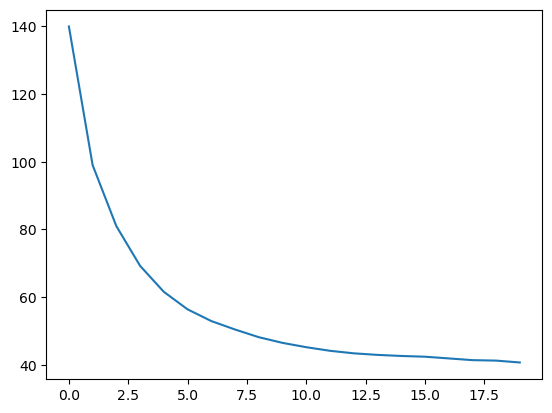

In [165]:
it = []
std = []
for i in range(20):
    kmeans = KMeans(64, 2, i)
    labels_ = kmeans(tf.expand_dims(features, 0))
    df['labels_'] = np.squeeze(labels_)
    it.append(i)
    std.append(np.std(df['labels_'].value_counts()))
plt.plot(it, std)
plt.show()

In [161]:
np.std(df['labels_'].value_counts())

45.20543385479228

In [ ]:
it, std

# Benchmark with scikit-learn

In [84]:
from time import time

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [85]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.289s	69927	0.635	0.678	0.656	0.523	0.652	0.153
random   	0.197s	70553	0.651	0.690	0.670	0.534	0.666	0.146
PCA-based	0.132s	72686	0.636	0.658	0.647	0.521	0.643	0.153
__________________________________________________________________________________


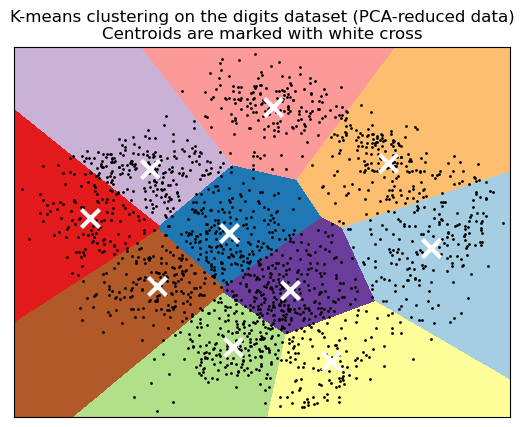

In [86]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
test_model